In [86]:
! pip install git+https://github.com/aimclub/eXplain-NNs &> /dev/null
! pip install torchmetrics &> /dev/null
! pip install giotto-ph==0.2.2 &> /dev/null
! pip install giotto-tda==0.6.0 &> /dev/null
! pip install umap-learn==0.5.3 &> /dev/null

In [88]:
# Importing all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import optuna
import os
import eXNN.topology

import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Create a Neural Network class with flexible settings
class FlexibleRegressionNN(nn.Module):
    def __init__(self, input_size: int, hidden_layers_sizes: list, dropout_rate: float) -> None:
        super(FlexibleRegressionNN, self).__init__()
        layers = list()

        # Define first and n-1 hidden layers
        neuron_num = input_size
        for size in hidden_layers_sizes:
            layers.append(nn.Linear(neuron_num, size))
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            neuron_num = size

        layers.append(nn.Linear(neuron_num, 1))
        self.model = nn.Sequential(*layers)

    # Define forward loop for NN
    def forward(self, x):
        return self.model(x)

In [4]:
# Define function for calculation RMSE
def root_mean_squared_error(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [73]:
# Define training and evaluating steps
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs):
    train_losses = list()
    test_losses = list()
    rmse_scores = list()

    for epoch in range(epochs):
        model.train()
        scheduler.step()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            all_outputs = list()
            all_targets = list()
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                all_outputs.append(outputs)
                all_targets.append(targets)

            test_loss /= len(test_loader)
            test_losses.append(test_loss)

            all_outputs = torch.cat(all_outputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            rmse_value = root_mean_squared_error(all_targets, all_outputs)
            rmse_scores.append(rmse_value)


        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, RMSE: {rmse_value:.4f}')

    # Loss and MAPE visualisation
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(rmse_scores, label='RMSE')
    plt.title('Loss and RMSE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

    return fig

In [9]:
# Read preprocessed bike dataset
prep_bike_df = pd.read_csv('./bike_dataset/prep_bike_data.csv')
prep_bike_df

,rank(season),yr,rank(mnth),rank(hr),holiday,rank(weekday),workingday,weathersit,rank(temp),rank(atemp),rank(hum),rank(windspeed),rank(casual),rank(registered),cnt
0,-1.16483,0,-1.737916,-2.035759,0,1.459083,0,1,-1.276942,-0.946560,0.770810,-1.532339,-0.774893,-1.037755,16
1,-1.16483,0,-1.737916,-1.533273,0,1.459083,0,1,-1.448913,-1.045073,0.734244,-1.532339,-0.356451,-0.699187,40
2,-1.16483,0,-1.737916,-1.259057,0,1.459083,0,1,-1.448913,-1.045073,0.734244,-1.532339,-0.564583,-0.766063,32
3,-1.16483,0,-1.737916,-1.059753,0,1.459083,0,1,-1.276942,-0.946560,0.509186,-1.532339,-0.774893,-1.126601,13
4,-1.16483,0,-1.737916,-0.897469,0,1.459083,0,1,-1.276942,-0.946560,0.509186,-1.532339,-1.690293,-2.448942,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,-1.16483,1,1.720548,0.883425,0,-0.788204,1,2,-1.117398,-1.152974,-0.121890,-0.127559,-0.204644,-0.057581,119
17375,-1.16483,1,1.720548,1.051068,0,-0.788204,1,2,-1.117398,-1.152974,-0.121890,-0.127559,-0.356451,-0.265968,89
17376,-1.16483,1,1.720548,1.255084,0,-0.788204,1,1,-1.117398,-1.152974,-0.121890,-0.127559,-0.417236,-0.250236,90
17377,-1.16483,1,1.720548,1.531407,0,-0.788204,1,1,-1.117398,-1.045073,-0.276442,-0.384024,-0.119057,-0.537970,61


In [78]:
# Define function for training network on non-full data
def batch_fit(batch_df):
    # Separate data into features and targets
    X = batch_df.iloc[:, :-1].values
    y = batch_df.iloc[:, -1].values
    y = y.reshape(-1, 1)

    # Data normalization
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    # Splitting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

    # Convertation data to PyTorch tensors
    train_features = torch.tensor(X_train, dtype=torch.float32)
    test_features = torch.tensor(X_test, dtype=torch.float32)
    train_targets = torch.tensor(y_train, dtype=torch.float32)
    test_targets = torch.tensor(y_test, dtype=torch.float32)    

    # Creating DataLoader
    train_data = TensorDataset(train_features, train_targets)
    test_data = TensorDataset(test_features, test_targets)

    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    # Model initialization
    model = FlexibleRegressionNN(14, [119, 151, 139, 247, 124], 0.23)

    # Define optimizator and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=6.490481802107004e-05, weight_decay=0.1)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

    # Perform training
    fig = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=40)

    return model.state_dict(), fig

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.1530, Test Loss: 0.0177, RMSE: 0.1338
Epoch 2/40, Train Loss: 0.0944, Test Loss: 0.0148, RMSE: 0.1223
Epoch 3/40, Train Loss: 0.0746, Test Loss: 0.0119, RMSE: 0.1097
Epoch 4/40, Train Loss: 0.0601, Test Loss: 0.0099, RMSE: 0.0996
Epoch 5/40, Train Loss: 0.0500, Test Loss: 0.0082, RMSE: 0.0910
Epoch 6/40, Train Loss: 0.0398, Test Loss: 0.0075, RMSE: 0.0870
Epoch 7/40, Train Loss: 0.0325, Test Loss: 0.0064, RMSE: 0.0804
Epoch 8/40, Train Loss: 0.0267, Test Loss: 0.0067, RMSE: 0.0824
Epoch 9/40, Train Loss: 0.0220, Test Loss: 0.0051, RMSE: 0.0714
Epoch 10/40, Train Loss: 0.0179, Test Loss: 0.0039, RMSE: 0.0628
Epoch 11/40, Train Loss: 0.0154, Test Loss: 0.0041, RMSE: 0.0647
Epoch 12/40, Train Loss: 0.0136, Test Loss: 0.0047, RMSE: 0.0691
Epoch 13/40, Train Loss: 0.0123, Test Loss: 0.0025, RMSE: 0.0499
Epoch 14/40, Train Loss: 0.0110, Test Loss: 0.0032, RMSE: 0.0573
Epoch 15/40, Train Loss: 0.0098, Test Loss: 0.0021, RMSE: 0.0467
Epoch 16/40, Train Loss: 0.0091, T

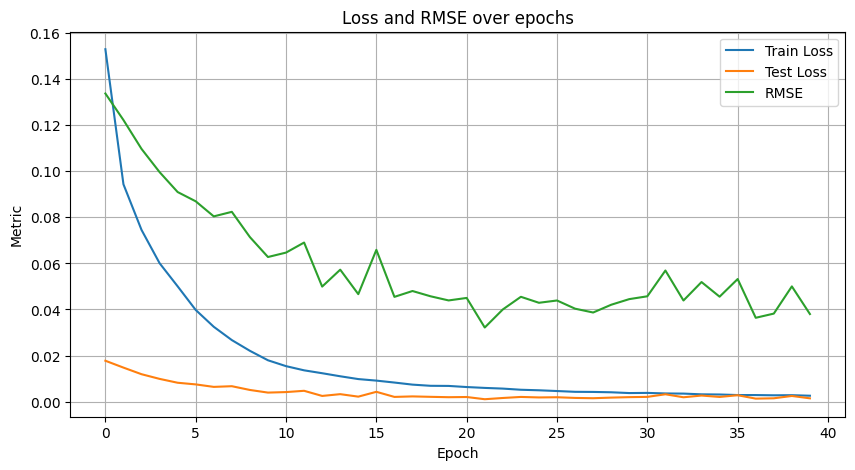

In [79]:
weights, fig = batch_fit(prep_bike_df)

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.2930, Test Loss: 0.0772, RMSE: 0.2787
Epoch 2/40, Train Loss: 0.1981, Test Loss: 0.0551, RMSE: 0.2360
Epoch 3/40, Train Loss: 0.1472, Test Loss: 0.0362, RMSE: 0.1913
Epoch 4/40, Train Loss: 0.1253, Test Loss: 0.0257, RMSE: 0.1610
Epoch 5/40, Train Loss: 0.1140, Test Loss: 0.0206, RMSE: 0.1437
Epoch 6/40, Train Loss: 0.1095, Test Loss: 0.0207, RMSE: 0.1444
Epoch 7/40, Train Loss: 0.0986, Test Loss: 0.0167, RMSE: 0.1297
Epoch 8/40, Train Loss: 0.0956, Test Loss: 0.0163, RMSE: 0.1283
Epoch 9/40, Train Loss: 0.0878, Test Loss: 0.0150, RMSE: 0.1234
Epoch 10/40, Train Loss: 0.0931, Test Loss: 0.0149, RMSE: 0.1227
Epoch 11/40, Train Loss: 0.0827, Test Loss: 0.0138, RMSE: 0.1180
Epoch 12/40, Train Loss: 0.0802, Test Loss: 0.0139, RMSE: 0.1183
Epoch 13/40, Train Loss: 0.0799, Test Loss: 0.0142, RMSE: 0.1194
Epoch 14/40, Train Loss: 0.0760, Test Loss: 0.0140, RMSE: 0.1193
Epoch 15/40, Train Loss: 0.0728, Test Loss: 0.0140, RMSE: 0.1185
Epoch 16/40, Train Loss: 0.0755, T

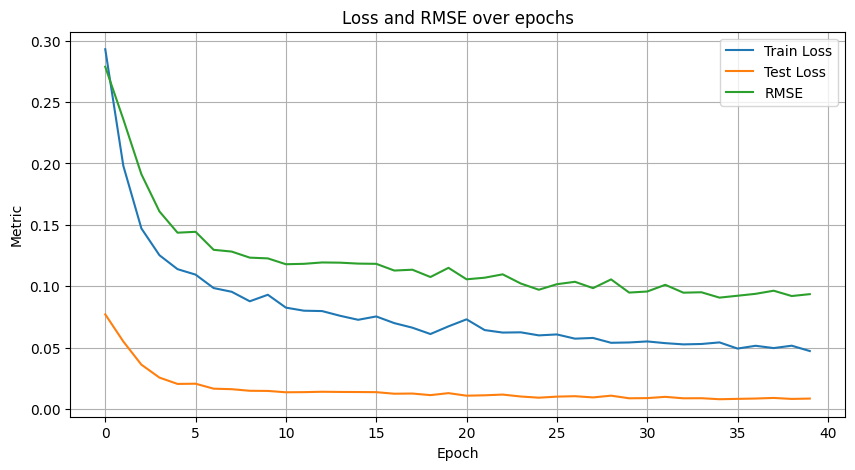

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.4721, Test Loss: 0.1644, RMSE: 0.4028
Epoch 2/40, Train Loss: 0.2451, Test Loss: 0.0789, RMSE: 0.2797
Epoch 3/40, Train Loss: 0.1498, Test Loss: 0.0350, RMSE: 0.1870
Epoch 4/40, Train Loss: 0.1171, Test Loss: 0.0213, RMSE: 0.1459
Epoch 5/40, Train Loss: 0.0991, Test Loss: 0.0161, RMSE: 0.1269
Epoch 6/40, Train Loss: 0.0868, Test Loss: 0.0140, RMSE: 0.1190
Epoch 7/40, Train Loss: 0.0847, Test Loss: 0.0140, RMSE: 0.1186
Epoch 8/40, Train Loss: 0.0807, Test Loss: 0.0128, RMSE: 0.1135
Epoch 9/40, Train Loss: 0.0732, Test Loss: 0.0106, RMSE: 0.1031
Epoch 10/40, Train Loss: 0.0713, Test Loss: 0.0101, RMSE: 0.1010
Epoch 11/40, Train Loss: 0.0655, Test Loss: 0.0091, RMSE: 0.0960
Epoch 12/40, Train Loss: 0.0614, Test Loss: 0.0088, RMSE: 0.0942
Epoch 13/40, Train Loss: 0.0602, Test Loss: 0.0076, RMSE: 0.0877
Epoch 14/40, Train Loss: 0.0549, Test Loss: 0.0073, RMSE: 0.0859
Epoch 15/40, Train Loss: 0.0538, Test Loss: 0.0067, RMSE: 0.0822
Epoch 16/40, Train Loss: 0.0513, T

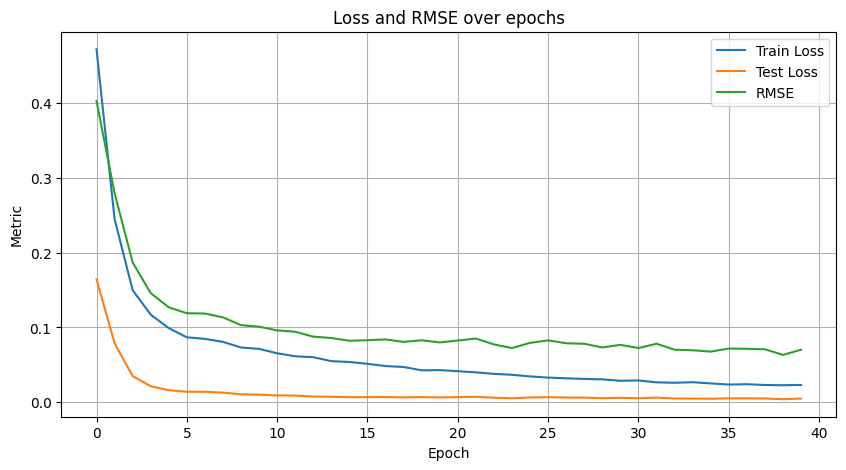

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.1662, Test Loss: 0.0276, RMSE: 0.1684
Epoch 2/40, Train Loss: 0.1177, Test Loss: 0.0210, RMSE: 0.1473
Epoch 3/40, Train Loss: 0.0963, Test Loss: 0.0172, RMSE: 0.1321
Epoch 4/40, Train Loss: 0.0841, Test Loss: 0.0174, RMSE: 0.1320
Epoch 5/40, Train Loss: 0.0726, Test Loss: 0.0144, RMSE: 0.1195
Epoch 6/40, Train Loss: 0.0635, Test Loss: 0.0117, RMSE: 0.1079
Epoch 7/40, Train Loss: 0.0576, Test Loss: 0.0112, RMSE: 0.1057
Epoch 8/40, Train Loss: 0.0500, Test Loss: 0.0105, RMSE: 0.1020
Epoch 9/40, Train Loss: 0.0454, Test Loss: 0.0090, RMSE: 0.0938
Epoch 10/40, Train Loss: 0.0417, Test Loss: 0.0081, RMSE: 0.0895
Epoch 11/40, Train Loss: 0.0369, Test Loss: 0.0082, RMSE: 0.0899
Epoch 12/40, Train Loss: 0.0350, Test Loss: 0.0062, RMSE: 0.0794
Epoch 13/40, Train Loss: 0.0302, Test Loss: 0.0061, RMSE: 0.0798
Epoch 14/40, Train Loss: 0.0271, Test Loss: 0.0056, RMSE: 0.0757
Epoch 15/40, Train Loss: 0.0251, Test Loss: 0.0064, RMSE: 0.0817
Epoch 16/40, Train Loss: 0.0227, T

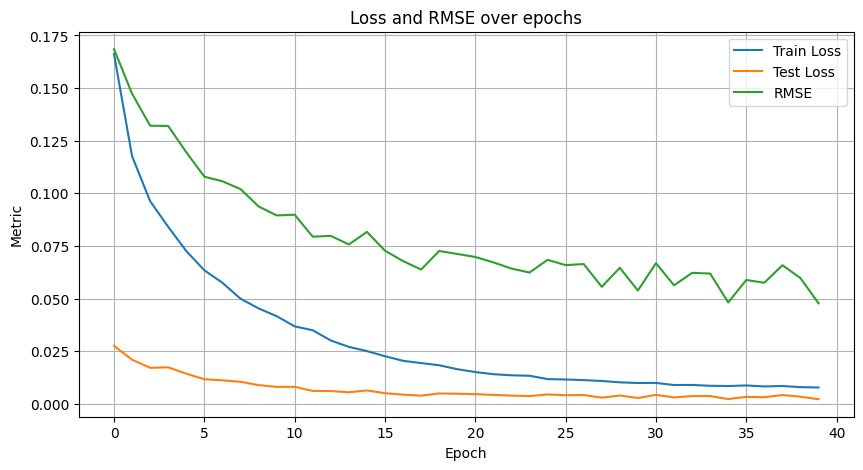

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.1498, Test Loss: 0.0198, RMSE: 0.1404
Epoch 2/40, Train Loss: 0.0879, Test Loss: 0.0156, RMSE: 0.1246
Epoch 3/40, Train Loss: 0.0719, Test Loss: 0.0133, RMSE: 0.1148
Epoch 4/40, Train Loss: 0.0599, Test Loss: 0.0112, RMSE: 0.1054
Epoch 5/40, Train Loss: 0.0524, Test Loss: 0.0106, RMSE: 0.1025
Epoch 6/40, Train Loss: 0.0446, Test Loss: 0.0087, RMSE: 0.0932
Epoch 7/40, Train Loss: 0.0385, Test Loss: 0.0078, RMSE: 0.0881
Epoch 8/40, Train Loss: 0.0337, Test Loss: 0.0066, RMSE: 0.0810
Epoch 9/40, Train Loss: 0.0289, Test Loss: 0.0061, RMSE: 0.0781
Epoch 10/40, Train Loss: 0.0250, Test Loss: 0.0049, RMSE: 0.0696
Epoch 11/40, Train Loss: 0.0208, Test Loss: 0.0046, RMSE: 0.0678
Epoch 12/40, Train Loss: 0.0183, Test Loss: 0.0040, RMSE: 0.0628
Epoch 13/40, Train Loss: 0.0156, Test Loss: 0.0043, RMSE: 0.0655
Epoch 14/40, Train Loss: 0.0140, Test Loss: 0.0033, RMSE: 0.0571
Epoch 15/40, Train Loss: 0.0124, Test Loss: 0.0025, RMSE: 0.0502
Epoch 16/40, Train Loss: 0.0110, T

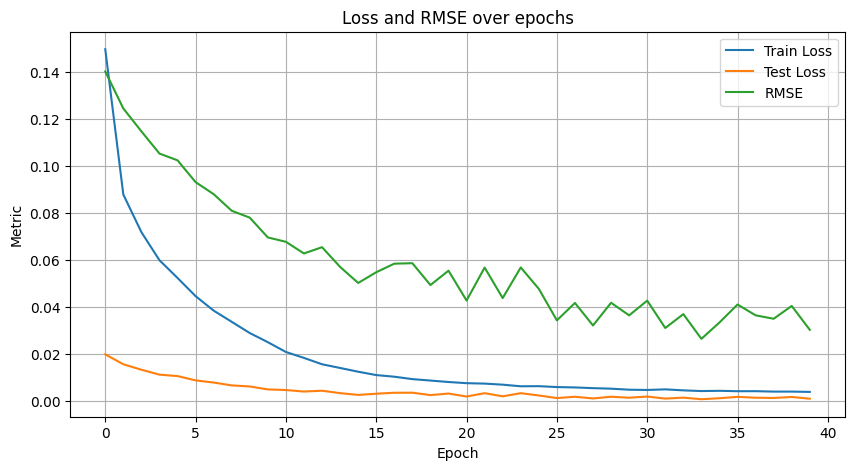

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.1727, Test Loss: 0.0249, RMSE: 0.1580
Epoch 2/40, Train Loss: 0.0867, Test Loss: 0.0162, RMSE: 0.1270
Epoch 3/40, Train Loss: 0.0702, Test Loss: 0.0128, RMSE: 0.1131
Epoch 4/40, Train Loss: 0.0581, Test Loss: 0.0106, RMSE: 0.1029
Epoch 5/40, Train Loss: 0.0496, Test Loss: 0.0091, RMSE: 0.0953
Epoch 6/40, Train Loss: 0.0414, Test Loss: 0.0088, RMSE: 0.0941
Epoch 7/40, Train Loss: 0.0343, Test Loss: 0.0069, RMSE: 0.0832
Epoch 8/40, Train Loss: 0.0283, Test Loss: 0.0074, RMSE: 0.0862
Epoch 9/40, Train Loss: 0.0234, Test Loss: 0.0060, RMSE: 0.0777
Epoch 10/40, Train Loss: 0.0198, Test Loss: 0.0057, RMSE: 0.0758
Epoch 11/40, Train Loss: 0.0174, Test Loss: 0.0048, RMSE: 0.0697
Epoch 12/40, Train Loss: 0.0157, Test Loss: 0.0057, RMSE: 0.0755
Epoch 13/40, Train Loss: 0.0138, Test Loss: 0.0054, RMSE: 0.0736
Epoch 14/40, Train Loss: 0.0122, Test Loss: 0.0051, RMSE: 0.0715
Epoch 15/40, Train Loss: 0.0112, Test Loss: 0.0031, RMSE: 0.0556
Epoch 16/40, Train Loss: 0.0105, T

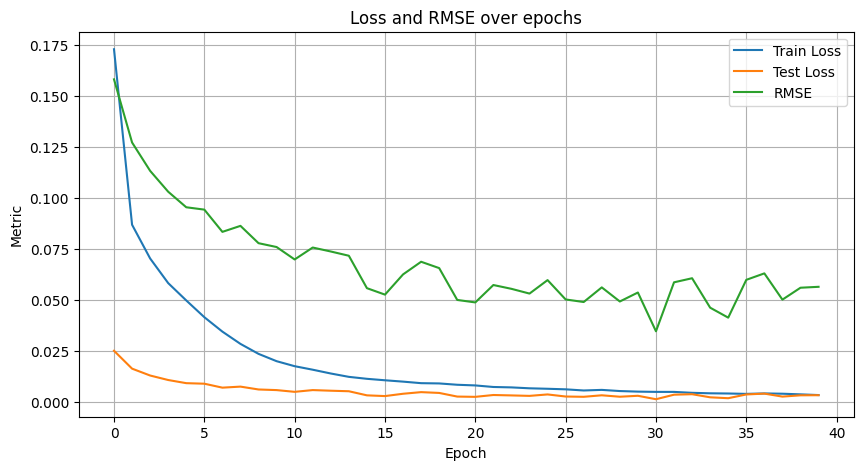

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.1399, Test Loss: 0.0177, RMSE: 0.1340
Epoch 2/40, Train Loss: 0.0849, Test Loss: 0.0154, RMSE: 0.1248
Epoch 3/40, Train Loss: 0.0669, Test Loss: 0.0114, RMSE: 0.1074
Epoch 4/40, Train Loss: 0.0550, Test Loss: 0.0088, RMSE: 0.0946
Epoch 5/40, Train Loss: 0.0437, Test Loss: 0.0077, RMSE: 0.0886
Epoch 6/40, Train Loss: 0.0360, Test Loss: 0.0066, RMSE: 0.0819
Epoch 7/40, Train Loss: 0.0295, Test Loss: 0.0066, RMSE: 0.0818
Epoch 8/40, Train Loss: 0.0239, Test Loss: 0.0066, RMSE: 0.0816
Epoch 9/40, Train Loss: 0.0196, Test Loss: 0.0055, RMSE: 0.0742
Epoch 10/40, Train Loss: 0.0168, Test Loss: 0.0048, RMSE: 0.0699
Epoch 11/40, Train Loss: 0.0145, Test Loss: 0.0047, RMSE: 0.0693
Epoch 12/40, Train Loss: 0.0125, Test Loss: 0.0037, RMSE: 0.0614
Epoch 13/40, Train Loss: 0.0116, Test Loss: 0.0031, RMSE: 0.0561
Epoch 14/40, Train Loss: 0.0102, Test Loss: 0.0037, RMSE: 0.0616
Epoch 15/40, Train Loss: 0.0096, Test Loss: 0.0042, RMSE: 0.0653
Epoch 16/40, Train Loss: 0.0087, T

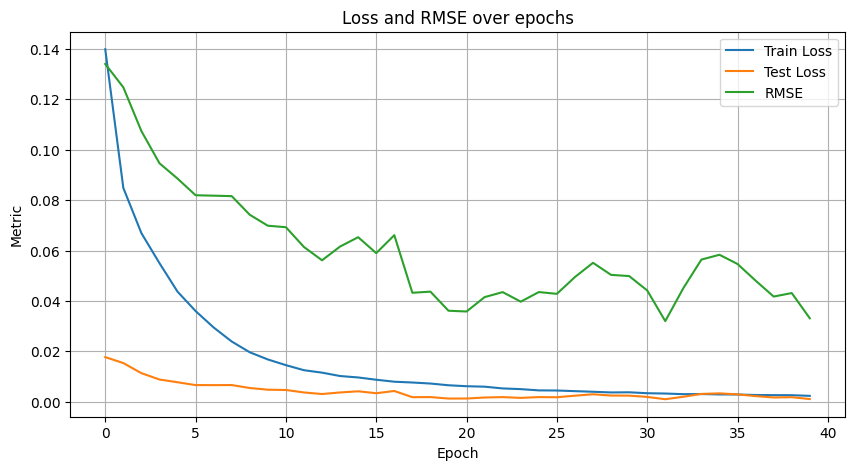

In [83]:
# Create cycle for training network with different amounts of data
for batch in range(3000, len(prep_bike_df), 3000):
    # Getting part of the dataset
    df_batch = prep_bike_df.head(batch)

    # Training model and getting it's weights
    model_weights, fig = batch_fit(df_batch)

    # Saving weights and losses
    os.makedirs(f'./bike_output/weights_graphs_mlp_dataamout{batch}', exist_ok=True)
    torch.save(model_weights, f'./bike_output/weights_graphs_mlp_dataamout{batch}/weights_mlp_dataamout{batch}.pth')
    fig.savefig(f'./bike_output/weights_graphs_mlp_dataamout{batch}/loss_and_rmse_mlp_dataamount{batch}.png', dpi=300, bbox_inches='tight')

# Getting part of the dataset
df_batch = prep_bike_df.head(len(prep_bike_df))

# Training model and getting it's weights
model_weights, fig = batch_fit(df_batch)

# Saving weights and losses
os.makedirs(f'./bike_output/weights_graphs_mlp_dataamout{len(prep_bike_df)}', exist_ok=True)
torch.save(model_weights, f'./bike_output/weights_graphs_mlp_dataamout{len(prep_bike_df)}/weights_mlp_dataamout{len(prep_bike_df)}.pth')
fig.savefig(f'./bike_output/weights_graphs_mlp_dataamout{len(prep_bike_df)}/loss_and_rmse_mlp_dataamount{len(prep_bike_df)}.png', dpi=300, bbox_inches='tight')

/Users/pavel/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Train Loss: 0.1404, Test Loss: 0.0218, RMSE: 0.1478
Epoch 2/40, Train Loss: 0.0858, Test Loss: 0.0147, RMSE: 0.1218
Epoch 3/40, Train Loss: 0.0654, Test Loss: 0.0123, RMSE: 0.1115
Epoch 4/40, Train Loss: 0.0526, Test Loss: 0.0098, RMSE: 0.1000
Epoch 5/40, Train Loss: 0.0419, Test Loss: 0.0078, RMSE: 0.0890
Epoch 6/40, Train Loss: 0.0334, Test Loss: 0.0066, RMSE: 0.0819
Epoch 7/40, Train Loss: 0.0266, Test Loss: 0.0056, RMSE: 0.0749
Epoch 8/40, Train Loss: 0.0217, Test Loss: 0.0060, RMSE: 0.0780
Epoch 9/40, Train Loss: 0.0175, Test Loss: 0.0056, RMSE: 0.0758
Epoch 10/40, Train Loss: 0.0145, Test Loss: 0.0039, RMSE: 0.0629
Epoch 11/40, Train Loss: 0.0130, Test Loss: 0.0034, RMSE: 0.0589
Epoch 12/40, Train Loss: 0.0111, Test Loss: 0.0024, RMSE: 0.0495
Epoch 13/40, Train Loss: 0.0105, Test Loss: 0.0036, RMSE: 0.0609
Epoch 14/40, Train Loss: 0.0091, Test Loss: 0.0024, RMSE: 0.0491
Epoch 15/40, Train Loss: 0.0085, Test Loss: 0.0020, RMSE: 0.0447
Epoch 16/40, Train Loss: 0.0078, T

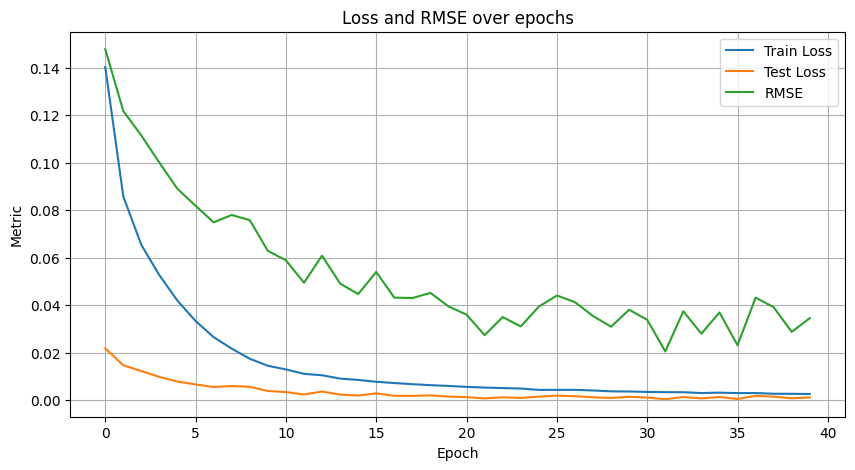

TypeError: get_nn_barcodes() missing 1 required positional argument: 'layers'

In [ ]:
# Separate data into features and targets
X = prep_bike_df.iloc[:, :-1].values
y = prep_bike_df.iloc[:, -1].values
y = y.reshape(-1, 1)

# Data normalization
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

# Convertation data to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.float32)    

# Creating DataLoader
train_data = TensorDataset(train_features, train_targets)
test_data = TensorDataset(test_features, test_targets)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

# Model initialization
model = FlexibleRegressionNN(14, [119, 151, 139, 247, 124], 0.23)

# Define optimizator and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=6.490481802107004e-05, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

# Perform training
fig = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=40)

model = model.to(torch.device('cpu'))
data = torch.stack([test_data[i][0] for i in range(100)])
barcodes = eXNN.topology.get_nn_barcodes(model, data, layers = ['layer2'], hom_type = "standard", coefs_type = "2")
barcode = barcodes['layer2']

In [ ]:
eXNN.topology.plot_barcode(barcode)

In [ ]:
eXNN.topology.evaluate_barcode(barcode)